In [1]:
import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import CactusDataset
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

In [18]:

torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir)
#split dataset into train validation and test
train_size = int(0.7 * len(image_dataset))
val_size = int(0.20 * len(image_dataset))   
test_size = len(image_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size]) 


print('Length of dataset: ', len(image_dataset))

#USE ONLY TRAIN TO COMPUTE PREPROCESSING PARAMETERS
dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4)



Length of dataset:  17500


In [19]:
#Need to transform the batches into a single numpy array X_train, so that I feed it easier to the PCA function
dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4)
#Load data
X_train = []
y_train = []
for inputs, labels in dataloader:
    X_train.append(inputs.view(1, -1))
    y_train.append(labels)
X_train = torch.cat(X_train, 0)
y_train = torch.cat(y_train, 0)

#transform in np arrays
X_train = X_train.numpy()
y_train = y_train.numpy()

In [20]:
#Perform PCA
print(X_train.shape)
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)

(12250, 3072)


PCA(n_components=3072)

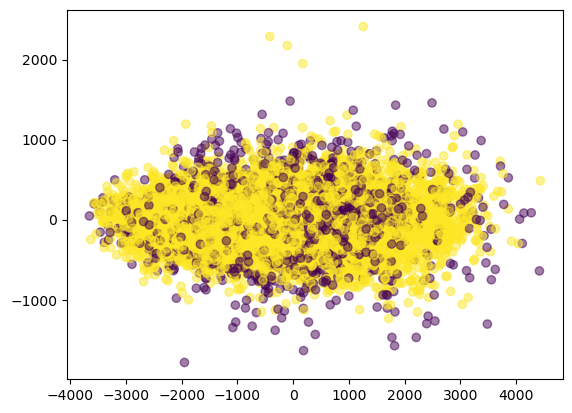

In [21]:
#scatter plot of PCA 2D together with labels
X_train_pca = pca.transform(X_train)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, alpha=0.5)
plt.show()


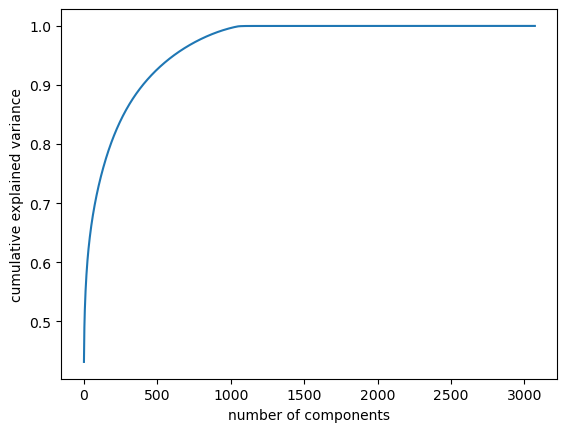

Number of components for 95% variance:  612


In [22]:
#plot number of features vs explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#print n_components for 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
print('Number of components for 95% variance: ', n_components)


## Histogram of pixel values

#### Before scaling

In [22]:
torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir)

print('Length of dataset: ', len(image_dataset))

#USe batch size of dimension of the whole dataset
dataloader = DataLoader(image_dataset, batch_size=len(image_dataset), num_workers=4)

Length of dataset:  17500


torch.Size([17920000])


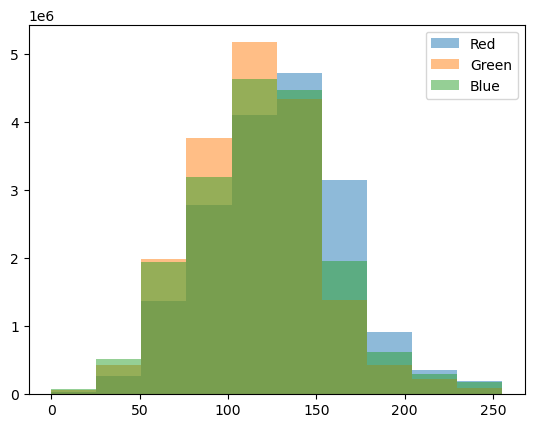

In [23]:
#Here the dataloader outputs a batch of len(image_dataset) thus i need only one loop of the dataloader to get all the data and plot all the pixel values
#print histogram of all pixel values frequency
for inputs, labels in dataloader:
    print(inputs[:,:,:,0].flatten().shape)
    plt.hist(inputs[:,:,:,0].flatten().numpy(), alpha=0.5, label='Red')
    plt.hist(inputs[:,:,:,1].flatten().numpy(), alpha=0.5, label='Green')
    plt.hist(inputs[:,:,:,2].flatten().numpy(), alpha=0.5, label='Blue')
    plt.legend(loc='upper right')
    plt.show()
    break
#print histogram of all range of values of each image
dataloader = DataLoader(image_dataset, batch_size=1, num_workers=4)
r_channel_range = []
g_channel_range = []
b_channel_range = []
#Here batch_size is 1, thus for each image I compute MAX-MIN and append it to the list of the corresponding channel
for inputs, labels in dataloader:
    r_channel_range.append(torch.max(inputs[0,:,:,0]) - torch.min(inputs[0,:,:,0]))
    g_channel_range.append(torch.max(inputs[0,:,:,1]) - torch.min(inputs[0,:,:,1]))
    b_channel_range.append(torch.max(inputs[0,:,:,2]) - torch.min(inputs[0,:,:,2]))


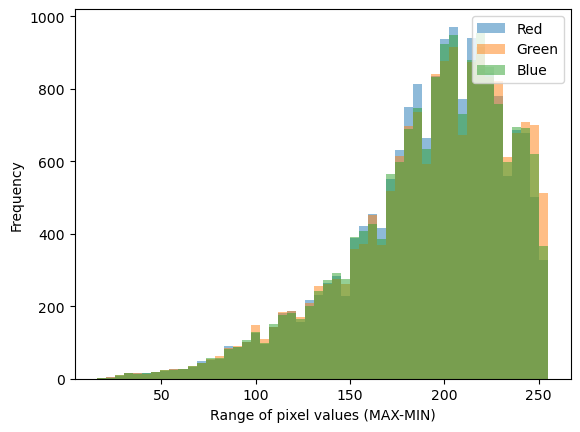

In [24]:
plt.hist(r_channel_range, bins=50, alpha=0.5, label='Red')
plt.hist(g_channel_range, bins=50, alpha=0.5, label='Green')
plt.hist(b_channel_range, bins=50, alpha=0.5, label='Blue')
plt.legend(loc='upper right')
#set axis labels
plt.xlabel('Range of pixel values (MAX-MIN)')
plt.ylabel('Frequency')
plt.show()

#### After scaling

In [26]:
torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir)

print('Length of dataset: ', len(image_dataset))

#USe batch size of dimension of the whole dataset
dataloader = DataLoader(image_dataset, batch_size=len(image_dataset), num_workers=4)

Length of dataset:  17500


torch.Size([17920000])


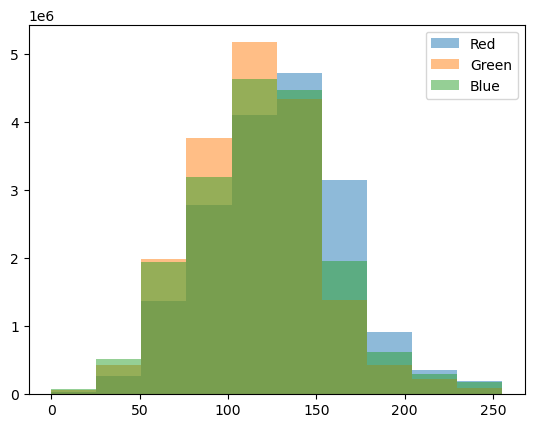

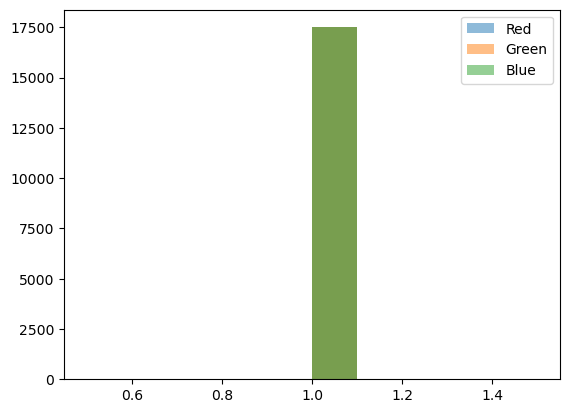

In [27]:
#print histogram of all pixel values frequency
for inputs, labels in dataloader:
    print(inputs[:,:, :,0].flatten().shape)
    plt.hist(inputs[:,:,:,0].flatten().numpy(), alpha=0.5, label='Red')
    plt.hist(inputs[:,:,:,1].flatten().numpy(), alpha=0.5, label='Green')
    plt.hist(inputs[:,:,:,2].flatten().numpy(), alpha=0.5, label='Blue')
    plt.legend(loc='upper right')
    plt.show()
    break
#print histogram of all range of values of each image
dataloader = DataLoader(image_dataset, batch_size=1, num_workers=4)
r_channel_range = []
g_channel_range = []
b_channel_range = []
for inputs, labels in dataloader:
    r_ch = inputs[0,:,:,0]
    g_ch = inputs[0,:,:,1]
    b_ch = inputs[0,:,:,2]
    #perform scaling here, so that every image has the same value MAX-MIN between (0,1)
    r_ch_norm = (r_ch - torch.min(r_ch)) / (torch.max(r_ch) - torch.min(r_ch))
    g_ch_norm = (g_ch - torch.min(g_ch)) / (torch.max(g_ch) - torch.min(g_ch))
    b_ch_norm = (b_ch - torch.min(b_ch)) / (torch.max(b_ch) - torch.min(b_ch))
    r_channel_range.append(torch.max(r_ch_norm) - torch.min(r_ch_norm))
    g_channel_range.append(torch.max(g_ch_norm) - torch.min(g_ch_norm))
    b_channel_range.append(torch.max(b_ch_norm) - torch.min(b_ch_norm))

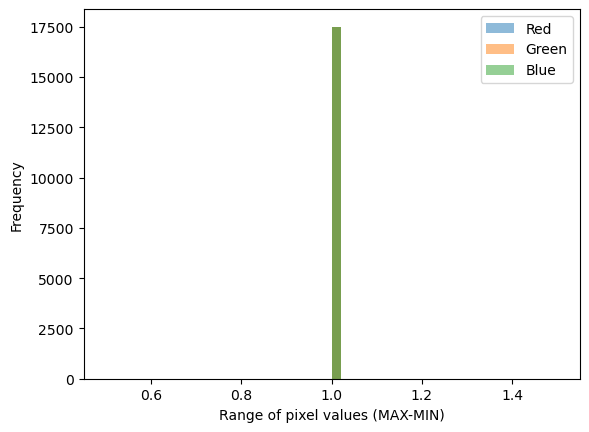

In [28]:
plt.hist(r_channel_range, bins=50, alpha=0.5, label='Red')
plt.hist(g_channel_range, bins=50, alpha=0.5, label='Green')
plt.hist(b_channel_range, bins=50, alpha=0.5, label='Blue')
plt.legend(loc='upper right')
#set axis labels
plt.xlabel('Range of pixel values (MAX-MIN)')
plt.ylabel('Frequency')
plt.show()

## Standardization of images

#### Before standardization

In [14]:
torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, transform=transforms.Compose([transforms.ToTensor()]))
#Split dataset into train validation and test
train_size = int(0.7 * len(image_dataset))
val_size = int(0.20 * len(image_dataset))   
test_size = len(image_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size]) 


print('Length of dataset: ', len(image_dataset))

#USE ONLY TRAIN TO COMPUTE PREPROCESSING PARAMETERS
dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=4)

#still here, i have a batch of len(train_dataset), thus only one next of dataloader
#I use train_dataset to avoid data leakage of val and test (the way I index the tensors is different form the previous cells, because now in output we have tensors and not PIL image
#(see when i declare CactusData i also add transforms.ToTensor()))
images, _ = next(iter(dataloader))
print(images.shape)
r_ch_mean = images[:, 0, :, :].mean().item()
g_ch_mean = images[:, 1, :, :].mean().item()
b_ch_mean = images[:, 2, :, :].mean().item()
r_ch_std = images[:, 0, :, :].std().item()
g_ch_std = images[:, 1, :, :].std().item()
b_ch_std = images[:, 2, :, :].std().item()

means = [r_ch_mean, g_ch_mean, b_ch_mean]
stds = [r_ch_std, g_ch_std, b_ch_std]

print('Means: ', means)
print('Stds: ', stds)

Length of dataset:  17500


torch.Size([12250, 3, 32, 32])
Means:  [0.5040580034255981, 0.45228394865989685, 0.4686073362827301]
Stds:  [0.15081556141376495, 0.1395294964313507, 0.15291152894496918]


#### After standardization

In [16]:
torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)]))
#Split dataset into train validation and test
train_size = int(0.7 * len(image_dataset))
val_size = int(0.20 * len(image_dataset))   
test_size = len(image_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size]) 


print('Length of dataset: ', len(image_dataset))

#I added transforms.Normalize using means and stds computed in previous cell (one for each channel)
#USE ONLY TRAIN TO COMPUTE PREPROCESSING PARAMETERS
dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=4)

images, _ = next(iter(dataloader))
print(images.shape)
r_ch_mean = images[:, 0, :, :].mean().item()
g_ch_mean = images[:, 1, :, :].mean().item()
b_ch_mean = images[:, 2, :, :].mean().item()
r_ch_std = images[:, 0, :, :].std().item()
g_ch_std = images[:, 1, :, :].std().item()
b_ch_std = images[:, 2, :, :].std().item()

means = [r_ch_mean, g_ch_mean, b_ch_mean]
stds = [r_ch_std, g_ch_std, b_ch_std]

print('Means: ', means)
print('Stds: ', stds)

Length of dataset:  17500


torch.Size([12250, 3, 32, 32])
Means:  [6.157621896818455e-07, -2.4268092602142133e-07, -3.7267255947881495e-07]
Stds:  [1.0, 1.0, 0.9999999403953552]


## Histogram equalization

Before histogram equalization

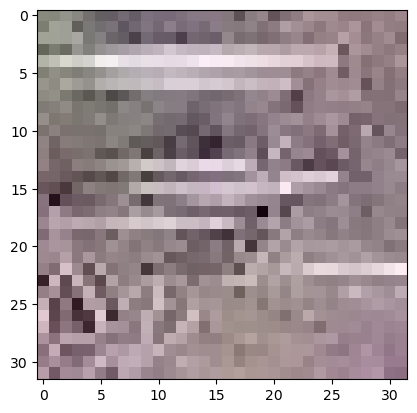

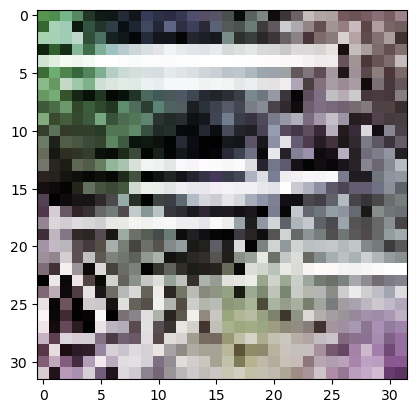

In [19]:
torch.manual_seed(42)
data_dir = '../../data/train/train'
csv_file = '../../data/train.csv'
TRAIN = 'train'
img = Image.open('../../data/train/train/0004be2cfeaba1c0361d39e2b000257b.jpg').convert('RGB')

#print img
plt.imshow(img)
plt.show()
#equalize img
transforms = transforms.RandomEqualize(p=1)
img = transforms(img)
plt.imshow(img)
plt.show()